In [1]:
from dipy.sims.voxel import DKI_signal, multi_tensor_dki
import dipy.core.gradients as grad
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
import dipy.reconst.dki as dki

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
matplotlib.style.use('fivethirtyeight')

In [4]:
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)

In [5]:
bvecs = np.concatenate([np.array([[0, 0, 0]]), hsph_updated.vertices, 
                        np.array([[0, 0, 0]]), hsph_updated.vertices])
bvals = np.concatenate([[0], np.ones(hsph_updated.vertices.shape[0]) * 1000., 
                        [0], np.ones(hsph_updated.vertices.shape[0]) * 2500.])

In [6]:
bvals.shape

(122,)

In [7]:
gtab = grad.gradient_table(bvals, bvecs)

In [8]:
MK = 1.05

In [9]:
l1 = AD =  0.001890620638080
l2 = l3 = RD =  2.546896809600547e-04

In [10]:
FA = 0.85 
MD = 0.8 / 1000.

In [11]:
dt = [l1, 0, l2, 0, 0, l3]

In [12]:
kt = [MK, MK, MK, 0, 0, 0, 0, 0, 0, MK/3, MK/3, MK/3, 0, 0, 0]

In [13]:
n_snr = 10
n_sims = 10000

In [14]:
snr = 1/np.linspace(0.03, 0.1, n_snr)

In [15]:
model = dki.DiffusionKurtosisModel(gtab)

In [16]:
sim_mk = np.empty((n_snr, n_sims))
sim_fa = np.empty((n_snr, n_sims))
sim_md = np.empty((n_snr, n_sims))

In [17]:
for snr_idx, this_snr in enumerate(snr):
    for sim_idx in range(n_sims):
        sig = DKI_signal(gtab, dt, kt, S0=1.0, snr=this_snr)
        fit = model.fit(sig)
        sim_mk[snr_idx, sim_idx] = fit.mk()
        sim_fa[snr_idx, sim_idx] = fit.fa
        sim_md[snr_idx, sim_idx] = fit.md 

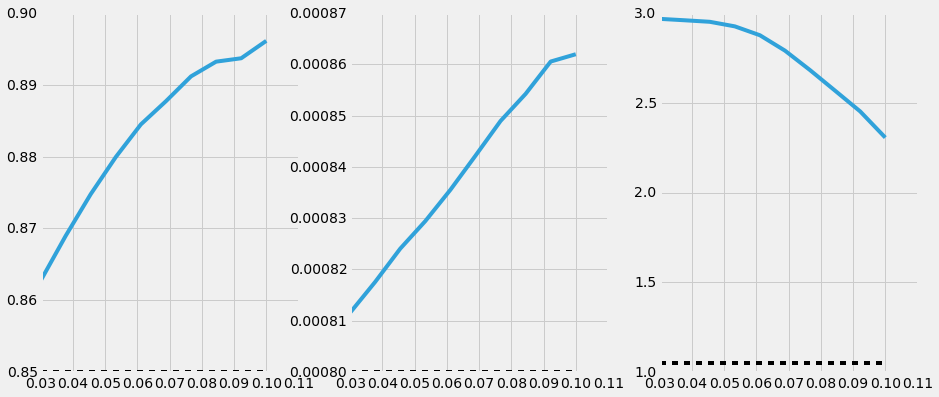

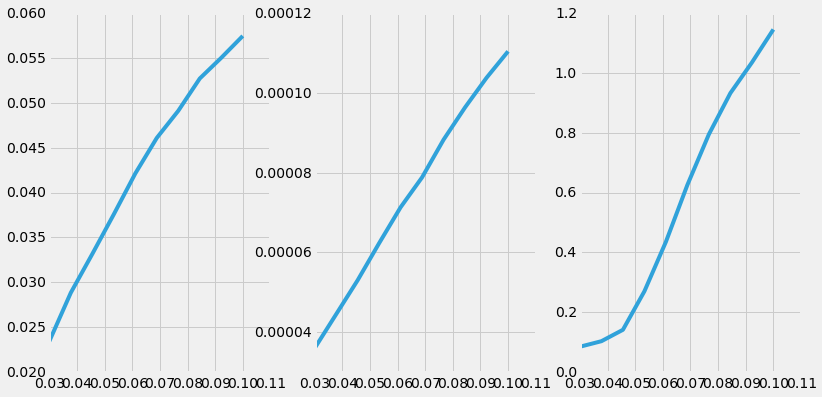

In [18]:
fig, ax = plt.subplots(1, 3)
ax[0].plot(1 / snr, np.mean(sim_fa, -1))
ax[0].plot(1 / snr, np.ones(snr.shape) * FA, 'k--')
ax[1].plot(1 / snr, np.mean(sim_md, -1))
ax[1].plot(1 / snr, np.ones(snr.shape) * MD, 'k--')
ax[2].plot(1 / snr, np.mean(sim_mk, -1))
ax[2].plot(1 / snr, np.ones(snr.shape) * MK, 'k--')
fig.set_size_inches([14, 6])

fig, ax = plt.subplots(1, 3)
ax[0].plot(1 / snr, np.std(sim_fa, -1))
ax[1].plot(1 / snr, np.std(sim_md, -1))
ax[2].plot(1 / snr, np.std(sim_mk, -1))
fig.set_size_inches([12, 6])